# Dynamics via acceleration maps

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from analysis import analysis

mu_factor = 6  # conversion to microns
min_factor = 8  # conversion to minutes
n_stats = 500  # delta between each recorded observation
dt = n_stats * 0.002 * min_factor / 60  # dt between each recorded observation, in hr


#### Load grid by grid
- Load `fulltake.pkl`, which is all of the runs for a config

In [20]:
from glob import glob

data = []
for gid in range(8):
    df = pd.read_pickle(f"data/medium/grid_id{gid}.pkl")
    df.rename(columns={"grid id" : "gid", "run id" : "rid"}, inplace=True)
    df["timestamp[hr]"] = df.index * dt
    df.x *= mu_factor
    df.y *= mu_factor
    data.append(df)

print(f"Loaded {len(data)} configurations.")
[print(f"\t - Grid {gid}: {len(df)} total data points | {len(df.rid.unique())} runs | {len(df[df.rid==0])} data points / run") for gid, df in zip(range(8), data)]
display(data[0])


Loaded 8 configurations.
	 - Grid 0: 48000 total data points | 48 runs | 1000 data points / run
	 - Grid 1: 48000 total data points | 48 runs | 1000 data points / run
	 - Grid 2: 48000 total data points | 48 runs | 1000 data points / run
	 - Grid 3: 47997 total data points | 48 runs | 1000 data points / run
	 - Grid 4: 48000 total data points | 48 runs | 1000 data points / run
	 - Grid 5: 47836 total data points | 48 runs | 998 data points / run
	 - Grid 6: 48000 total data points | 48 runs | 1000 data points / run
	 - Grid 7: 34210 total data points | 35 runs | 966 data points / run


,x,y,vx,vy,D,beta,tau,gid,rid,timestamp[hr]
0,225.000000,150.000000,0.000000,0.000000,0.1,0.6,1.0,0,45,0.000000
1,224.819084,150.021606,-0.162814,-0.066759,0.1,0.6,1.0,0,45,0.133333
2,223.484064,150.262179,-0.201649,0.006210,0.1,0.6,1.0,0,45,0.266667
3,223.209487,150.167471,-0.088255,0.010217,0.1,0.6,1.0,0,45,0.400000
4,222.539826,149.827094,-0.073387,-0.063897,0.1,0.6,1.0,0,45,0.533333
...,...,...,...,...,...,...,...,...,...,...
995,80.141333,151.175121,0.232155,0.105710,0.1,0.6,1.0,0,9,132.666667
996,81.761151,151.576261,0.353855,0.082644,0.1,0.6,1.0,0,9,132.800000
997,84.232916,151.700165,0.234395,0.004962,0.1,0.6,1.0,0,9,132.933333
998,85.160013,152.134311,0.031572,-0.011019,0.1,0.6,1.0,0,9,133.066667


### Position dist

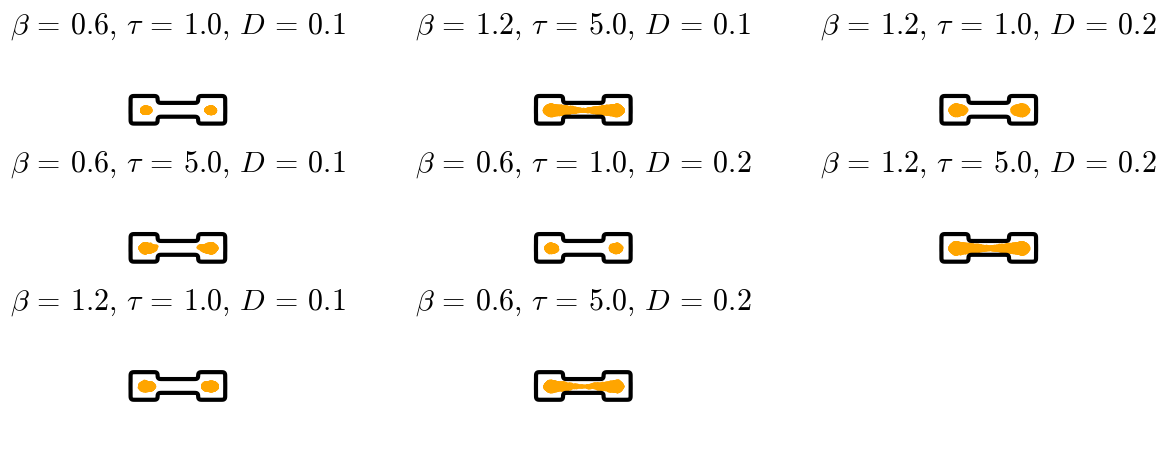

In [3]:
analysis.position_dist(data, mu_factor)

### Hopping times

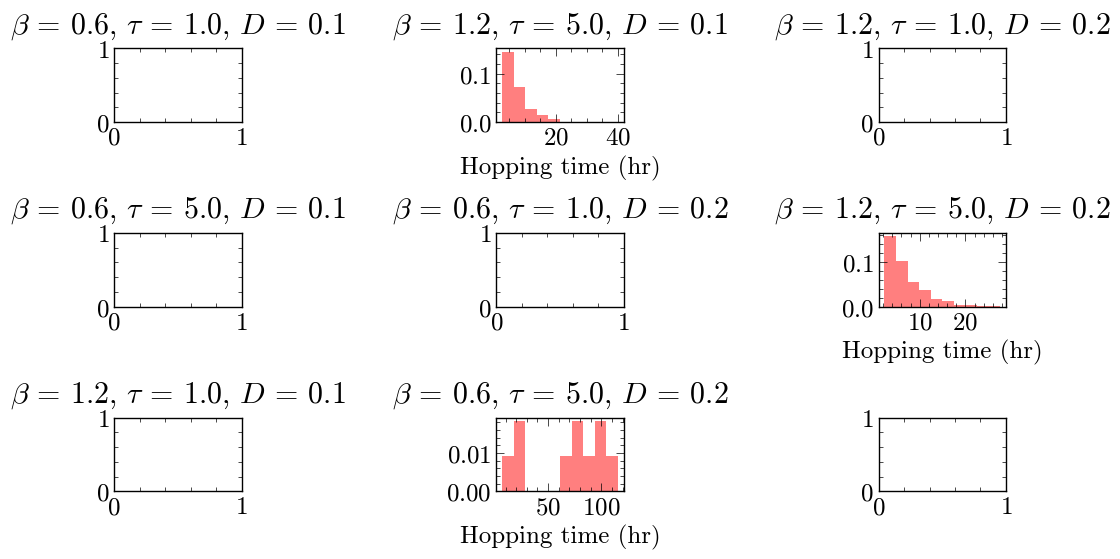

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(10, 6))

x, y = np.meshgrid([0, 1, 2], [0, 1, 2])

for i, j, df in zip(x.flatten(), y.flatten(), data):
    beta = df.beta.iloc[0]
    tau = df.tau.iloc[0]
    D = df.D.iloc[0]
    axs[i, j].set_title(rf"$\beta$ = {beta}, $\tau$ = {tau}, $D$ = {D}", y=1.1)

    hop_times = []
    for rid, d in df.groupby("rid"):
        for t in analysis.get_hopping_times(d, mu_factor):
            hop_times.append(t)

    if len(hop_times) == 0:
        continue

    axs[i, j].hist(hop_times, color="red", alpha=0.5, density=True)
    axs[i, j].set_xlabel("Hopping time (hr)")
        
plt.tight_layout()
plt.subplots_adjust(hspace=1.5, wspace=2)
plt.show()


## Acceleration maps and flow lines

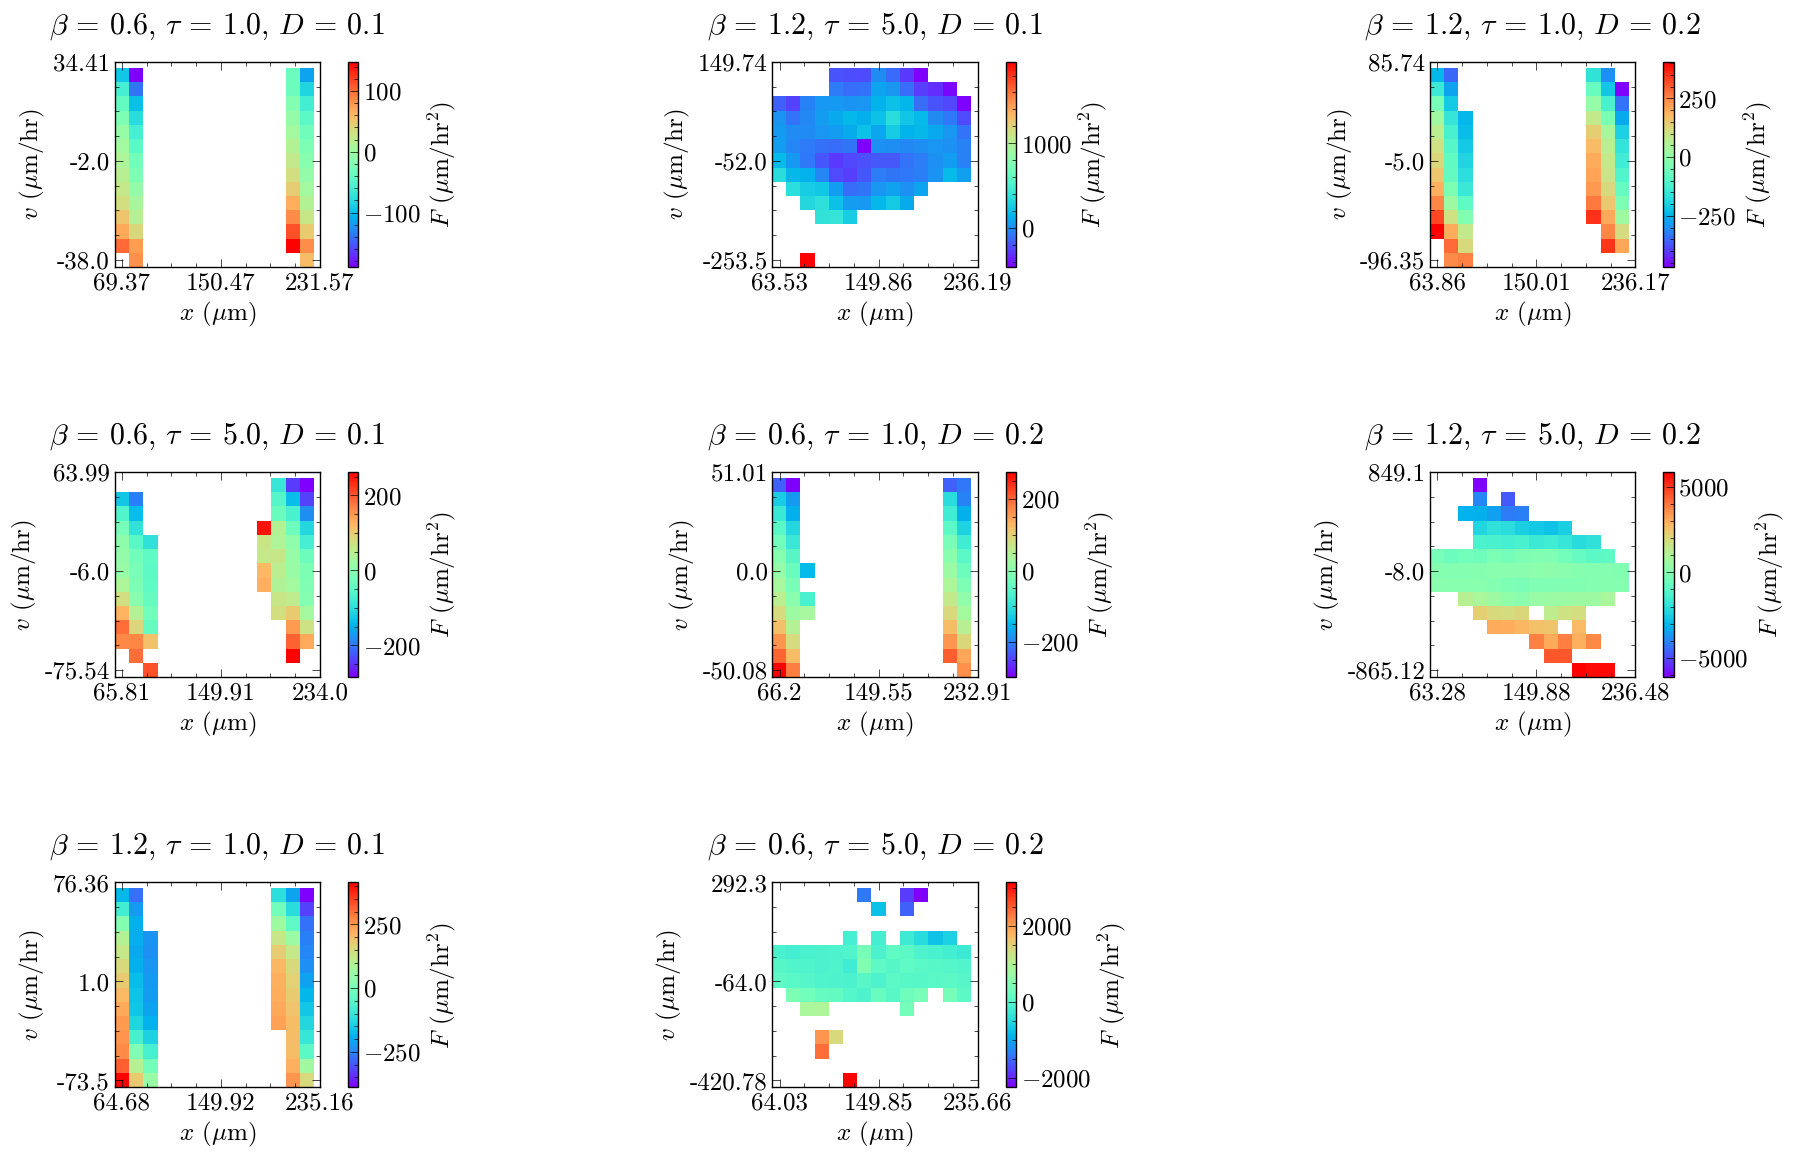

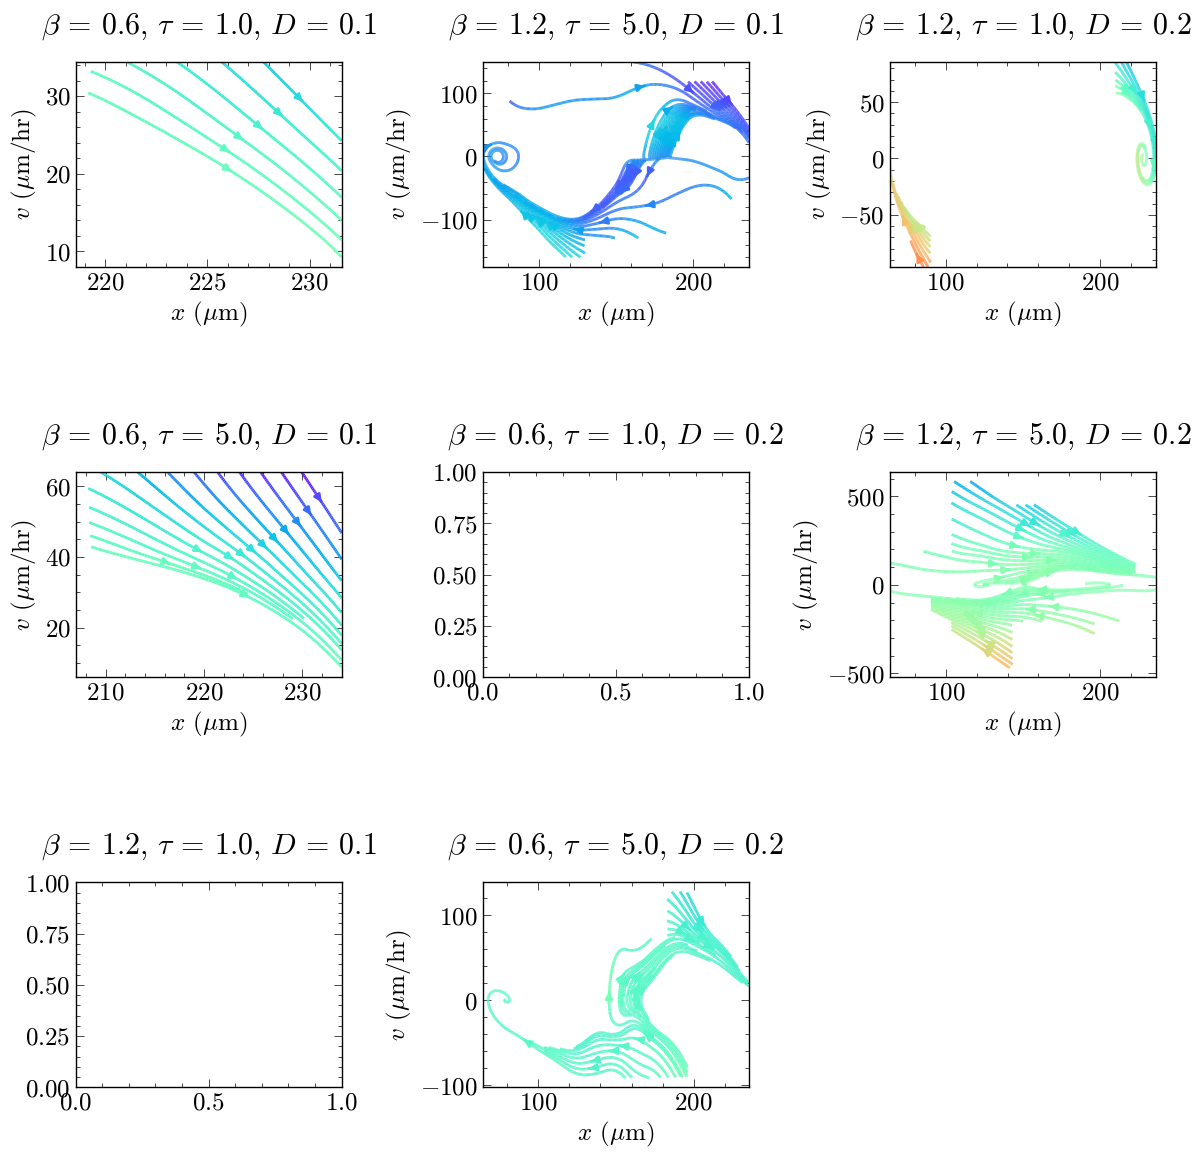

In [72]:
fig1, axs1 = plt.subplots(3, 3, figsize=(20, 12))
fig2, axs2 = plt.subplots(3, 3, figsize=(12, 12))

x, y = np.meshgrid([0, 1, 2], [0, 1, 2])

for i, j, df_gid in zip(x.flatten(), y.flatten(), data):
    beta = df_gid.beta.iloc[0]
    tau = df_gid.tau.iloc[0]
    D = df_gid.D.iloc[0]
    axs1[i, j].set_title(rf"$\beta$ = {beta}, $\tau$ = {tau}, $D$ = {D}", y=1.1)
    axs2[i, j].set_title(rf"$\beta$ = {beta}, $\tau$ = {tau}, $D$ = {D}", y=1.1)

    # x, v, a values for this entire config
    grid_x_v_a = []

    # compute speed and acc for each run
    for rid, df_rid in df_gid.groupby("rid"):
        x_v_a = analysis.calc_v_a_from_position(df_rid.x, dt)
        x_v_a["gid"] = df_rid.gid.iloc[0]
        x_v_a["rid"] = df_rid.rid.iloc[0]
        grid_x_v_a.append(x_v_a)

    # consider the entire config to set bounds of acc field
    grid_x_v_a = pd.concat(grid_x_v_a)
    bounds = grid_x_v_a.agg(["min", "max"])
    xmin, xmax = bounds["x"]
    vmin, vmax = bounds["v"]

    nbins = 14
    dx = (xmax - xmin) / nbins
    dv = (vmax - vmin) / nbins

    x1 = ("x", xmin, dx)
    x2 = ("v", vmin, dv)

    analysis.get_bin_indices(grid_x_v_a, nbins, x1, x2)

    # make acc field for each run
    # acc_map = []
    # for rid, df_rid in grid_x_v_a.groupby("rid"):
    #     map_a = analysis.map_a(df_rid, nbins, "x_bin", "v_bin")
    #     acc_map.append(map_a)

    # acc_map = np.nanmean(acc_map, axis=0)

    acc_map = analysis.map_a(grid_x_v_a, nbins, "x_bin", "v_bin")

    # PLOT ACC MAP
    im = axs1[i, j].imshow(acc_map, origin="lower", interpolation="none", cmap="rainbow")
    axs1[i, j].set_xticks(
        [0, nbins // 2, nbins],
        [round(xmin, 2), round((xmin + xmax) / 2, 2), round(xmax, 2)],
    )
    axs1[i, j].set_yticks(
        [0, nbins // 2, nbins],
        [round(vmin, 2), round((vmin + vmax) / 2, 0), round(vmax, 2)],
    )
    cbar = fig1.colorbar(im, ax=axs1[i, j])
    cbar.set_label(r"$F$ ($\mu$m/hr$^2$)")
    axs1[i, j].set_xlabel(r"$x$ ($\mu$m)")
    axs1[i, j].set_ylabel(r"$v$ ($\mu$m/hr)")

    # PLOT FLOW LINES
    X, Y = np.meshgrid(np.linspace(xmin, xmax, nbins), np.linspace(vmin, vmax, nbins))

    # axs2[i, j].streamplot(X, Y, Y, acc_map, linewidth=2, color=acc_map, cmap="rainbow", density=1.5)
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(vmin, vmax, 100)
    pts = np.array(list(zip(x, y)))

    try:
        axs2[i, j].streamplot(X, Y, Y, acc_map, linewidth=2, color=acc_map, cmap="rainbow", start_points=pts, integration_direction="both", density=10)
        axs2[i, j].set_xlabel(r"$x$ ($\mu$m)")
        axs2[i, j].set_ylabel(r"$v$ ($\mu$m/hr)")
    except:
        None
    # c = plt.get_cmap("Set2")(3)
    # plt.quiver(X, Y, Y, acc_map, np.where(acc_map > 0, 1, 0), cmap="Set2", width=0.007)
    # plt.streamplot(X, Y, Y, acc_map, linewidth=2, color=c)
    # plt.xlabel(r"$x$ ($\mu$m)")
    # plt.ylabel(r"$v$ ($\mu$m/hr)")
    # plt.show()

axs1[2, 2].remove()
axs2[2, 2].remove()

fig1.tight_layout()
fig1.subplots_adjust(hspace=1)

fig2.tight_layout()
fig2.subplots_adjust(hspace=1)

plt.show()

In [65]:
x = X[0]
y = Y[:, 0]
x = np.linspace(x.min(), x.max(), 100)
y = np.linspace(y.min(), y.max(), 100)
pts = np.array(list(zip(x, y)))

plt.streamplot(X, Y, Y, acc_map, linewidth=2, color=acc_map, cmap="rainbow", start_points=pts, integration_direction="forward", density=10)

array([[ 6.32847510e+01, -8.65115749e+02],
       [ 6.50341951e+01, -8.47800475e+02],
       [ 6.67836393e+01, -8.30485201e+02],
       [ 6.85330834e+01, -8.13169926e+02],
       [ 7.02825276e+01, -7.95854652e+02],
       [ 7.20319717e+01, -7.78539378e+02],
       [ 7.37814159e+01, -7.61224103e+02],
       [ 7.55308600e+01, -7.43908829e+02],
       [ 7.72803042e+01, -7.26593555e+02],
       [ 7.90297483e+01, -7.09278280e+02],
       [ 8.07791925e+01, -6.91963006e+02],
       [ 8.25286366e+01, -6.74647732e+02],
       [ 8.42780808e+01, -6.57332458e+02],
       [ 8.60275249e+01, -6.40017183e+02],
       [ 8.77769690e+01, -6.22701909e+02],
       [ 8.95264132e+01, -6.05386635e+02],
       [ 9.12758573e+01, -5.88071360e+02],
       [ 9.30253015e+01, -5.70756086e+02],
       [ 9.47747456e+01, -5.53440812e+02],
       [ 9.65241898e+01, -5.36125537e+02],
       [ 9.82736339e+01, -5.18810263e+02],
       [ 1.00023078e+02, -5.01494989e+02],
       [ 1.01772522e+02, -4.84179714e+02],
       [ 1.

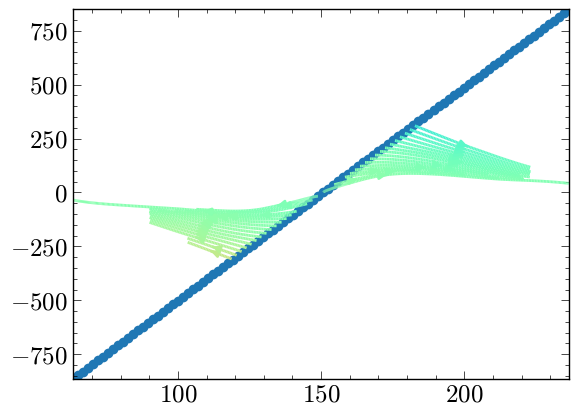

In [68]:
plt.streamplot(X, Y, Y, acc_map, linewidth=2, color=acc_map, cmap="rainbow", start_points=pts, integration_direction="forward", density=10)
plt.scatter(pts[:, 0], pts[:, 1])